In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../") 

import os
import yaml
import numpy as np
import textwrap
import json

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import matplotlib.gridspec as gridspec
plt.rcParams["font.family"] = "Optima"
plt.rcParams["font.weight"] = "light"

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import arviz as az

from epimodel import preprocess_data, run_model, EpidemiologicalParameters
from epimodel.plotting.intervention_plots import combine_npi_samples

In [2]:
def load_jsons(paths, vars=("seasonality_beta1", "seasonality_max_R_day")):
    traces = []
    df = pd.DataFrame()
    for fn in paths:
        with open('../../'+fn) as f:
            d = json.load(f)
            d["MODEL"] = re.search('model(.*)_', d['model_config_name']).groups()[0]
            d["DATA"] = re.search('data(.*)', d['model_config_name']).groups()[0]
            d["LABEL"] = f"Seasonal {d['MODEL']} et al." #\n{d['DATA']} data" # NB: Change for 2x2 plots
            if d['DATA'] == "BraunerTE":
                d["LABEL"] += "\n(temperate Europe)"
            print(f"Loaded {d['MODEL']} model, {d['DATA']} data. Rhat: {d['rhat']}")
            traces.append(d)

            cols = {v: np.array(d[v]) for v in vars}
            cols["label"] = d["LABEL"]
            df = df.append(pd.DataFrame(cols), ignore_index=True)

    cols = {v: np.array(df[v].values) for v in vars}
    cols["label"] = "Combined"
    df = df.append(pd.DataFrame(cols), ignore_index=True)
    return traces, df


Loaded Sharma model, Sharma data. Rhat: {'med': 0.9999120235443115, 'upper': 1.0012047290802002, 'lower': 0.9996274709701538, 'min': 1.004529595375061, 'max': 0.999599919967984}
Loaded Brauner model, BraunerTE data. Rhat: {'med': 1.0007307331166064, 'upper': 1.008199529252768, 'lower': 0.9996939147424313, 'max': 1.0219687977119518, 'min': 0.9993073171018397}

\begin{tabular}{l|r r r}
\textbf{Model} & \textbf{Median} & \textbf{50\% CI} & \textbf{95\% CI}\\
\hline
Seasonal Sharma et al. & 27.5 & 24.8 -- 30.0 & 20.0 -- 34.8 \\
Seasonal Brauner et al.
(temperate Europe) & 25.4 & 20.9 -- 29.7 & 11.8 -- 38.3 \\
Combined & 26.7 & 23.1 -- 29.9 & 14.1 -- 36.5 \\
\end{tabular}


\begin{tabular}{l|r r r}
\textbf{Model} & \textbf{Median} & \textbf{50\% CI} & \textbf{95\% CI}\\
\hline
Seasonal Sharma et al. & 43.1 & 39.7 -- 46.2 & 33.3 -- 51.6 \\
Seasonal Brauner et al.
(temperate Europe) & 40.5 & 34.6 -- 45.8 & 21.1 -- 55.4 \\
Combined & 42.1 & 37.5 -- 46.1 & 24.7 -- 53.4 \\
\end{tabular}



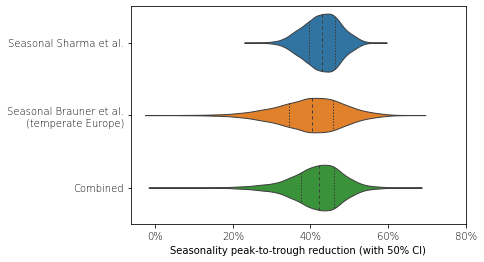

In [6]:
beta1_SRC=[
    "sensitivity_final/default_cmodelSharma_dataSharma/seasonality_basic_R_prior/20210429-044743-70284_summary.json",
    # NB: Change for 2x2 plots
    #"sensitivity_final/modelBrauner_dataSharma/seasonality_basic_R_prior/complex_seasonal_2021-04-30-025219_pid22787_summary.json",
    #"sensitivity_final/default_cmodelSharma_dataBraunerTE/seasonality_basic_R_prior/20210430-084421-36555_summary.json",
    "sensitivity_final/modelBrauner_dataBraunerTE/seasonality_basic_R_prior/complex_seasonal_2021-04-30-012232_pid18922_summary.json",
    ]

traces, df1 = load_jsons(beta1_SRC)
df1["top-to-trough"] = 100*(1-(1-df1["seasonality_beta1"]) / (1+df1["seasonality_beta1"]))
df1["gamma_percent"] = 100*df1["seasonality_beta1"]
df1["Seasonality peak"] = "January 1"

sns.violinplot(y="label", x="gamma_percent", data=df1, linewidth=1.0, inner="quartiles")
#plt.legend(shadow=False, fancybox=False, loc="upper right", bbox_to_anchor=(0.99, 0.99), fontsize=6)
#plt.title("", fontsize=10)
plt.xlabel("Seasonality amplitude γ (with 50% CI)")
plt.ylabel(None)
plt.xticks([0, 20, 40, 60, 80], ["0%", "20%", "40%", "60%", "80%"])
#plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80], ["0%", "", "20%", "", "40%", "", "60%", "", "80%"])
plt.savefig(f'figures/Fig_seasonality_gamma.pdf', bbox_inches='tight')
plt.close()

sns.violinplot(y="label", x="top-to-trough", data=df1, linewidth=1.0, inner="quartiles")
#plt.legend(shadow=False, fancybox=False, loc="upper right", bbox_to_anchor=(0.99, 0.99), fontsize=6)
#plt.title("", fontsize=10)
plt.xlabel("Seasonality peak-to-trough reduction (with 50% CI)")
plt.ylabel(None)
plt.xticks([0, 20, 40, 60, 80], ["0%", "20%", "40%", "60%", "80%"])
plt.savefig(f'figures/Fig_seasonality_extremes.pdf', bbox_inches='tight')

quants_gamma = df1.groupby('label').apply(lambda d: pd.Series(np.quantile(100 * d["seasonality_beta1"], (0.5, 0.25, 0.75, 0.025, 0.975)), index=['Med', 'C1a', 'C1b', 'C2a', 'C2b']))
quants_p2t = df1.groupby('label').apply(lambda d: pd.Series(np.quantile(100*(1-(1-d["seasonality_beta1"])/(1+d["seasonality_beta1"])), (0.5, 0.25, 0.75, 0.025, 0.975)), index=['Med', 'C1a', 'C1b', 'C2a', 'C2b']))

for quants in [quants_gamma, quants_p2t]:
    print(r"""
\begin{tabular}{l|r r r}
\textbf{Model} & \textbf{Median} & \textbf{50\% CI} & \textbf{95\% CI}\\
\hline
""" + '\n'.join([f"{l} & {d.Med:.1f} & {d.C1a:.1f} -- {d.C1b:.1f} & {d.C2a:.1f} -- {d.C2b:.1f} \\\\" for l, d in reversed(list(quants.iterrows()))]) +
    r"""
\end{tabular}
""")


In [7]:
q=df1.groupby('label').apply(lambda d: pd.Series(100 * np.quantile(d["seasonality_beta1"], (0.5, 0.25, 0.75, 0.025, 0.975)), index=['Med', 'C1a', 'C1b', 'C2a', 'C2b']))
list(q.iterrows())

[('Combined',
  Med    26.682800
  C1a    23.113430
  C1b    29.912489
  C2a    14.105520
  C2b    36.458289
  Name: Combined, dtype: float64),
 ('Seasonal Brauner et al.\n(temperate Europe)',
  Med    25.384486
  C1a    20.915517
  C1b    29.672610
  C2a    11.804489
  C2b    38.335123
  Name: Seasonal Brauner et al.\n(temperate Europe), dtype: float64),
 ('Seasonal Sharma et al.',
  Med    27.460432
  C1a    24.768831
  C1b    30.041450
  C2a    19.955587
  C2b    34.757178
  Name: Seasonal Sharma et al., dtype: float64)]

Loaded Sharma model, Sharma data. Rhat: {'med': 0.9999258518218994, 'upper': 1.0012623250484467, 'lower': 0.9996280074119568, 'min': 1.0059906244277954, 'max': 0.999599919967984}
Loaded Brauner model, BraunerTE data. Rhat: {'med': 1.0006241033117207, 'upper': 1.0050561081373988, 'lower': 0.9996727446982182, 'max': 1.011385924695284, 'min': 0.9993317402010178}


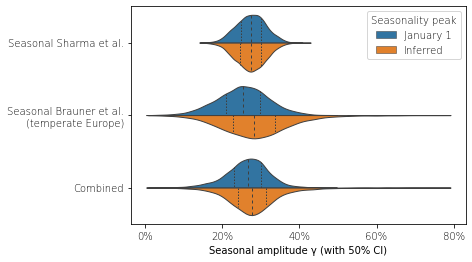

In [8]:
maxRday_SRC=[
    "sensitivity_final/default_cmodelSharma_dataSharma/seasonality_max_R_day_normal/20210429-044738-70161_summary.json",
    # NB: Change for 2x2 plots
    #"sensitivity_final/modelBrauner_dataSharma/seasonality_max_R_day_normal/complex_seasonal_2021-04-30-180604_pid56261_summary.json",
    #"sensitivity_final/default_cmodelSharma_dataBraunerTE/seasonality_max_R_day_normal/20210430-060658-29991_summary.json",
    "sensitivity_final/modelBrauner_dataBraunerTE/seasonality_max_R_day_normal/complex_seasonal_2021-04-30-050100_pid27982_summary.json",
    ]

traces, df2 = load_jsons(maxRday_SRC)
df2["gamma_percent"] = 100*df2["seasonality_beta1"]
df2["Seasonality peak"] = "Inferred"
dfc = df1.append(df2,  ignore_index=True)

sns.violinplot(y="label", x="seasonality_max_R_day", data=df2, linewidth=1.0, inner="quartiles", cut=0.0)
#plt.legend(shadow=False, fancybox=False, loc="upper right", bbox_to_anchor=(0.99, 0.99), fontsize=6)
#plt.title("", fontsize=10)
plt.xlabel("Inferred seasonality peak day (with 50% CI)")
plt.ylabel(None)
plt.xticks([1-31-30, 1-31, 1+0, 1+31, 1+31+28], ["Nov 1", "Dec 1", "Jan 1", "Feb 1", "Mar 1"])
plt.xlim((1-31-30-20, 1+31+28+20))
plt.savefig(f'figures/Fig_seasonality_maxRday.pdf', bbox_inches='tight')
plt.close()

sns.violinplot(y="label", x="gamma_percent", data=dfc, linewidth=1.0, hue="Seasonality peak", split=True, inner="quartiles", cut=0.0)
#plt.legend(shadow=False, fancybox=False, loc="upper right", bbox_to_anchor=(0.99, 0.99), fontsize=6)
#plt.title("", fontsize=10)
plt.xlabel("Seasonal amplitude γ (with 50% CI)")
plt.ylabel(None)
plt.xticks([0, 20, 40, 60, 80], ["0%", "20%", "40%", "60%", "80%"])
plt.savefig(f'figures/Fig_seasonality_gamma_with_maxRday.pdf', bbox_inches='tight')


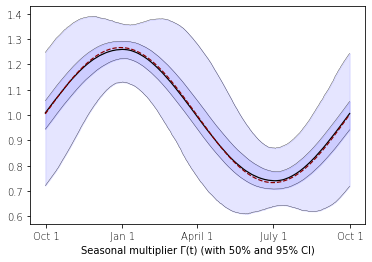

In [9]:
df2b = df2[df2.label=="Combined"]
#df2b.seasonality_beta1.values
#df2b.seasonality_max_R_day.values
days = np.arange(-365*0.25, 365*0.75, 0.5)
gamma_samples = 1.0 + df2b.seasonality_beta1.values * np.cos(2 * np.pi / 365.0 * (days.reshape((-1, 1)) + df2b.seasonality_max_R_day.values))
gamma_q = np.quantile(gamma_samples, (0.025, 0.25, 0.5, 0.75, 0.975), axis=1)

for i in range(5):
    plt.plot(days, gamma_q[i], "k", lw=1.2 if i==2 else 0.3)
plt.fill_between(days, gamma_q[0], gamma_q[4], alpha=0.10, color="b")
plt.fill_between(days, gamma_q[1], gamma_q[3], alpha=0.10, color="b")

gamma_q_0 = np.median(1.0 + df1[df1.label=="Combined"].seasonality_beta1.values * np.cos(2 * np.pi / 365.0 * (days.reshape((-1, 1)) + 1)), axis=1)
plt.plot(days, gamma_q_0, "--", lw=1.2, color="darkred")

plt.xlabel("Seasonal multiplier Γ(t) (with 50% and 95% CI)")
plt.ylabel(None)
plt.xticks([-90, 1, 91, 182, 274], ["Oct 1", "Jan 1", "April 1", "July 1", "Oct 1"])
plt.savefig(f'figures/Fig_seasonality_multiplier_with_maxRday.pdf', bbox_inches='tight')


In [ ]:
plt.plot?